In [19]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
import scipy.sparse as sp
from scipy.sparse import load_npz

import torch

import utils

In [2]:
_A_obs = load_npz('../data/datasets/CORA_ML.npz')

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Get true transition matrix, true logits matrix, synthetic transition matrix and synthetic logits matrix

In [4]:
P = train_graph.toarray() / np.array(train_graph.sum(axis=-1))

In [6]:
utils.load_dict('../logs/CORA-ML/Ours/Experiment_0/sampled_graphs/overlap.pickle')

{19: 0.26905499041721953, 38: 0.5298540468819106}

In [7]:
weights = np.load('../logs/CORA-ML/Ours/Experiment_0/weights/weights_38.npz')
Wdown, Wup = weights['W_down'], weights['W_up']

P_logits_synth = Wdown @ Wup
P_synth = torch.nn.functional.softmax(torch.tensor(P_logits_synth), dim=-1).numpy()

In [9]:
dict_of_matrices = {'P':P, 'P_synth':P_synth, 'P_logits_synth':P_logits_synth}
dict_of_eigvals = get_descending_eigenvalues(dict_of_matrices)

In [42]:
print(dict_of_eigvals['P_logits_synth'][:8])
print(dict_of_eigvals['P_logits_synth'][::100])

[1.         0.9491162  0.7836228  0.6421523  0.6421523  0.5932241
 0.5087572  0.42992303]
[1.0000000e+00 3.0917826e-09 2.8544522e-09 2.6864240e-09 2.5168294e-09
 2.3667852e-09 2.2183397e-09 2.0952644e-09 1.9743054e-09 1.8617630e-09
 1.7380145e-09 1.6313960e-09 1.5151901e-09 1.4147239e-09 1.3117474e-09
 1.2104275e-09 1.1179484e-09 9.9716957e-10 9.0721713e-10 8.2196011e-10
 7.2551087e-10 6.3872985e-10 5.4542110e-10 4.5021531e-10 3.6718065e-10
 2.8327929e-10 1.9376072e-10 9.7720616e-11 7.5875955e-12]


In [52]:
len(list(dict_of_eigvals.values())[0])

2810

In [54]:
x = np.empty(5)

In [56]:
x[:] = np.nan

In [60]:
# Thinning for dict_of_eigvals: First 9 of P_logits, and then for every other method every k-th
def thinning(dict_of_eigvals, step_size):
    N = len(list(dict_of_eigvals.values())[0])
    thinned_dict = {}
    for key, val in dict_of_eigvals.items():
        if key=='P_logits_synth':
            x = np.empty(N)
            x[:] = np.nan
            x[:8] = dict_of_eigvals[key][:8]
            x[8::step_size] = dict_of_eigvals[key][8::step_size]
            thinned_dict[key] = x
        else:
            x = np.empty(N)
            x[:] = np.nan
            x[::step_size] = dict_of_eigvals[key][::step_size]
            thinned_dict[key] = x
    return thinned_dict

In [61]:
thinned_dict = thinning(dict_of_eigvals, step_size=100)

In [112]:
def get_descending_eigenvalues(dict_of_matrices):
    dict_of_eigvals = dict_of_matrices
    for name, matrix in dict_of_matrices.items():
        eigvals = np.real(np.linalg.eig(matrix)[0])
        eigvals = np.sort(np.abs(eigvals))[::-1]
        dict_of_eigvals[name] = eigvals
    return dict_of_eigvals

def plot_eigenvalues(dict_of_eigvals, formats, save_path=None):
    f, axs = plt.subplots(figsize=(12, 12))
    for name, eigvals in dict_of_eigvals.items():
        marker, c = formats[name]
        eigvals /= max(eigvals)
        axs.scatter(np.arange(len(eigvals)), eigvals, s=450, marker=marker, facecolors='None', 
                    c=c, 
                    label=name)
    f.legend(loc='upper right', labels=[r'$P$', r'$P^\ast$', r'$W^\ast$'], 
             bbox_to_anchor=(0.85, 0.85),
             fontsize=70,
             markerscale=2,
             frameon=False,
             handletextpad=0)
    axs.tick_params(length=10, width=5)
    axslabel_size = 50
    plt.xticks([0, 1500, 2810], fontsize=axslabel_size)
    plt.yticks([0, 1], fontsize=axslabel_size)   
    if save_path:
        plt.savefig(fname=save_path, bbox_inches='tight')     
    plt.show()
    return

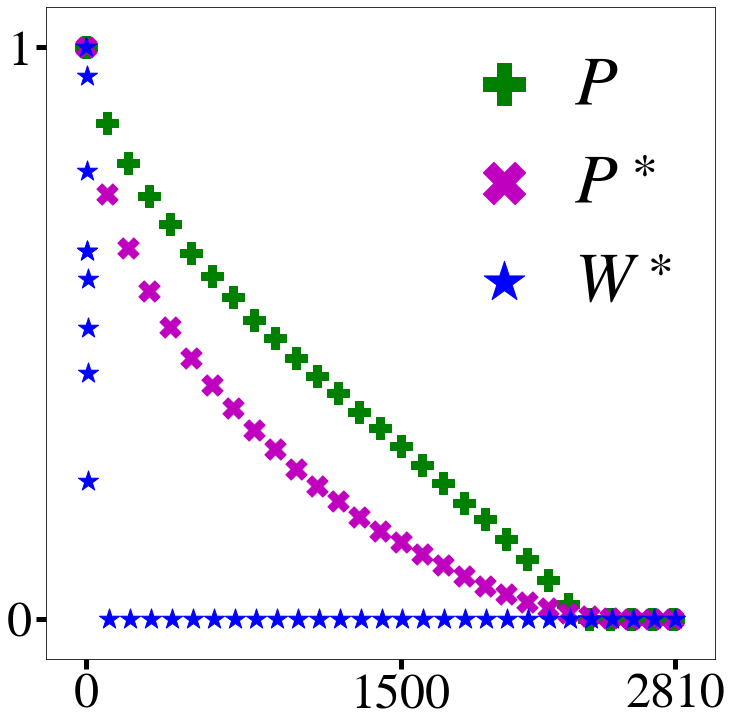

In [113]:
formats = {'P': ('P', 'g'),
           'P_synth':('X', 'm'), 
           'P_logits_synth':('*', 'b')}
plot_eigenvalues(thinned_dict, formats, save_path='../fig/eigenvalues.pdf')

In [88]:
dict_of_eigvals['P_logits'][:10]

array([58142.49480013,   281.68933756,   268.23464351,   249.49001058,
         208.97677085,   182.32426763,   181.73687861,   181.70926986,
         175.10307312,   166.784529  ])